In [1]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
# from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import scipy.io


In [2]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#E37A1B','#FFD966','#8EB85A','#A3E8F3','#376C72','#9F8BAD',"#ED9CCB", "#615C3B",'#FF9840',"#9F755F"] #Color scheme
markers = ['s', 'o','^', '*', 'X','>','d','<','v','+']
labels = list(string.ascii_uppercase)

MATLAB_filepath = "GVR_LISST"


plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

## Load data

In [3]:
import glob

lisst_dir = "LISST_ABS_USGS"
lisst_files = glob.glob(f"{lisst_dir}/*.csv")
print(f"📁 Found {len(lisst_files)} CSV files")
alpha_site_id = labels[0:len(lisst_files)]

lisst_data_dict = {}

# Prioritized variants for each column
column_priority = {
    "ABS": ["ABS (All)", "ABS"],
    "Turb": ["Turb (All)", "Turbidity"],  # ← optional now
    "SSC": ["SSC (All)", "Total SSC"],
    "Fines": ["Fines"],
    "Sands": ["Sands"],
    "Date": ["Date"]
}

for i, file_path in enumerate(lisst_files):
    fname = file_path.split("/")[-1]
    site_id = fname.replace(".csv", "")
    print(f"\n📄 Processing: {fname}")

    try:
        # Step 1: Read only column headers
        df_head = pd.read_csv(file_path, nrows=0)
        file_cols = df_head.columns.tolist()
        print(f"🔍 Columns found: {file_cols}")

        # Step 2: Select available columns
        selected_cols = {}
        for std_name, variants in column_priority.items():
            for variant in variants:
                if variant in file_cols:
                    selected_cols[variant] = std_name
                    break  # take the first available option

        # Step 3: Check for required columns (excluding Turb)
        required_columns = {"Date", "ABS", "SSC", "Fines", "Sands"}
        found_columns = set(selected_cols.values())

        if not required_columns.issubset(found_columns):
            print(f"⚠️ Skipping {fname}: Missing required columns → {required_columns - found_columns}")
            continue

        # Step 4: Read available columns
        df = pd.read_csv(file_path, usecols=selected_cols.keys())

        # Step 5: Rename to consistent names
        df = df.rename(columns=selected_cols)

        # Step 6: If Turb missing, add column with NaNs
        if "Turb" not in df.columns:
            df["Turb"] = np.nan
            print(f"ℹ️ Note: 'Turb' not found in {fname}, filled with NaN.")

        # Step 7: Store in dictionary
        lisst_data_dict[alpha_site_id[i]] = {'site_id': site_id,
                                             'datetime': df["Date"],
                                             'ABS': df["ABS"],
                                             "SSC": df["SSC"],
                                             'fines': df["Fines"],
                                             'sands': df["Sands"],
                                             'turb': df['Turb']}
        print(f"✅ Loaded {fname} with {len(df)} rows")

    except Exception as e:
        print(f"❌ Error reading {fname}: {type(e).__name__} — {e}")


📁 Found 7 CSV files

📄 Processing: Missouri_River_NebraskaCity_06807000.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Missouri_River_NebraskaCity_06807000.csv with 25 rows

📄 Processing: Rock_Creek_01648010.csv
🔍 Columns found: ['Date', 'ABS', 'Turbidity', 'Total SSC', 'Fines', 'Sands']
✅ Loaded Rock_Creek_01648010.csv with 68 rows

📄 Processing: Elwha_River_12046260.csv
🔍 Columns found: ['Date', 'ABS', 'ABS (All)', 'Turbidity', 'Turb (All)', 'Total SSC', 'SSC (All)', 'Fines', 'Sands']
✅ Loaded Elwha_River_12046260.csv with 73 rows

📄 Processing: Sacramento_River_11447650.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Sacramento_River_11447650.csv with 22 rows

📄 Processing: Illinois_River_05586300.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Illinois_River_05586300.csv with 25 r

## Gaussian function

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic
)

# Helper to extract hyperparameters from composite kernel

def extract_kernel_hyperparams(kernel):
    params = {}
    all_params = kernel.get_params()

    for name, val in all_params.items():
        # Only keep float/numeric hyperparameters (not subkernels)
        if isinstance(val, (float, int, np.float64, np.int64)):
            params[name] = val

    return params

# Gaussian Process Regression function

def GP(SAC_m, SSC_m, p, SAC_log=False, SSC_log=False, hyperparams=-999):
    # ---- Normalize x using min-max ----
    min_SAC = SAC_m.min()
    max_SAC = SAC_m.max()
    x_range = max_SAC - min_SAC
    if x_range < 1e-8:
        raise ValueError("Input x has too small a range to normalize reliably.")
    X = ((SAC_m - min_SAC) / x_range).reshape(-1, 1)

    # ---- Normalize y using min-max ----
    min_SSC = SSC_m.min()
    max_SSC = SSC_m.max()
    y_range = max_SSC - min_SSC
    if y_range < 1e-8:
        raise ValueError("Target y has too small a range to normalize reliably.")
    y = ((SSC_m - min_SSC) / y_range).reshape(-1, 1)

    if SAC_log:
        X = np.log10(X + 1e-8)
    if SSC_log:
        y = np.log10(y + 1e-6)

    # Kernel setup
    input_mean = np.abs(np.mean(X))
    noise_std = max(np.std(y), 1e-6)

    if hyperparams == -999:
        kernel = (
            ConstantKernel(0.3, (0.05, 0.8)) *
            RBF(length_scale=0.5, length_scale_bounds=(0.3, 2)) 
            # DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1 , 2))
            # RationalQuadratic(length_scale=0.5, length_scale_bounds=(0.3, 1),
            #                  alpha=1.0, alpha_bounds=(0.1, 100.0)) 
        )
    else:
        l = hyperparams[0]
        kernel = RBF(l, length_scale_bounds="fixed")

    SAC_pred = np.linspace(0, 1, p).reshape(-1, 1)

    # Fit with cross-validated alpha
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    # since envrionmental data, trying to find best alpha (noise) but have it not be too low
    alphas = np.logspace(-2, -1, 10)
    search = GridSearchCV(gp, {'alpha': alphas}, cv=5)
    search.fit(X, y.ravel())

    best_alpha = search.best_params_['alpha']
    gp_best = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=best_alpha)
    gp_best.fit(X, y.ravel())

    Y_pred_scaled, std_scaled = gp_best.predict(SAC_pred, return_std=True)

    # Invert y-scaling
    Y_pred_orig = Y_pred_scaled * y_range + min_SSC
    std_orig = std_scaled * y_range

    # Invert x-scaling for plotting
    SAC_pred_orig = SAC_pred.ravel() * x_range + min_SAC

    score = gp_best.score(X, y.ravel())
    log_marg = gp_best.log_marginal_likelihood()

    return SAC_pred_orig, Y_pred_orig, std_orig, score, log_marg, gp_best, best_alpha, (min_SAC, x_range), (min_SSC, y_range)


# Example usage (replace with your actual loop logic)
model_dictionary = {}
x_key = 'ABS'
y_key = 'SSC'

for i, site_id in enumerate(alpha_site_id):
    site_data = lisst_data_dict[site_id]
    xdata = site_data[x_key].to_numpy()
    ydata = site_data[y_key].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model, n_alpha, x_scale, y_scale = GP(xdata, ydata, p)
    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
    x_min, x_range = x_scale
    x_scaled = (xdata - x_min) / x_range
    ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)
    
    y_min, y_range = y_scale
    ypred = ypred_scaled * y_range + y_min
    std_pred = std_pred_scaled * y_range

    MSE_all = np.square(np.subtract(ydata, ypred)).mean()
    rmse_all = math.sqrt(MSE_all)
    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))
    print(f"Site {site_id} - RMSE: {rmse_all:.2f}, R^2: {r_score_all:.2f}, Alpha: {n_alpha}")

    model_dictionary[site_id] = {
        'hyperparams': kernel_params,
        'num_samp': len(xdata),
        'x': xdata,
        'y': ydata,
        'n_pred': ypred,
        'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
        'scores': {
            'GP_score': GP_score_all,
            'GP_logmarg': GP_logmarg_all,
            'r_score': r_score_all,
            'rmse': rmse_all,
            'std': std_pred,
            'alpha': n_alpha,
        },
        'model': GP_model,
        'x_scaling': x_scale,  # (min_SAC, x_range)
        'y_scaling': y_scale,  # (min_SSC, y_range)
    }



/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn

Site A - RMSE: 118.60, R^2: -8.73, Alpha: 0.03593813663804628


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site B - RMSE: 261.05, R^2: -0.50, Alpha: 0.021544346900318832
Site C - RMSE: 28.76, R^2: -0.48, Alpha: 0.01
Site D - RMSE: 19.21, R^2: -7.85, Alpha: 0.1


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

Site E - RMSE: 4.38, R^2: -64.13, Alpha: 0.01
Site F - RMSE: 38.32, R^2: -5.77, Alpha: 0.1


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn

Site G - RMSE: 28.66, R^2: -5.65, Alpha: 0.01291549665014884


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Site A model hyperparams: {'k1__constant_value': 0.4487178911185129, 'k2__length_scale': 1.1277990936160096}
Site B model hyperparams: {'k1__constant_value': 0.5254686987695594, 'k2__length_scale': 1.2092976970817648}
Site C model hyperparams: {'k1__constant_value': 0.7474163057572575, 'k2__length_scale': 0.9563757805306794}
Site D model hyperparams: {'k1__constant_value': 0.23729863806364207, 'k2__length_scale': 0.8251007330335435}
Site E model hyperparams: {'k1__constant_value': 0.46189225057770683, 'k2__length_scale': 0.40284013577200506}
Site F model hyperparams: {'k1__constant_value': 0.5049068296746096, 'k2__length_scale': 1.0822987991198956}
Site G model hyperparams: {'k1__constant_value': 0.4485602461285016, 'k2__length_scale': 0.6041473781708283}


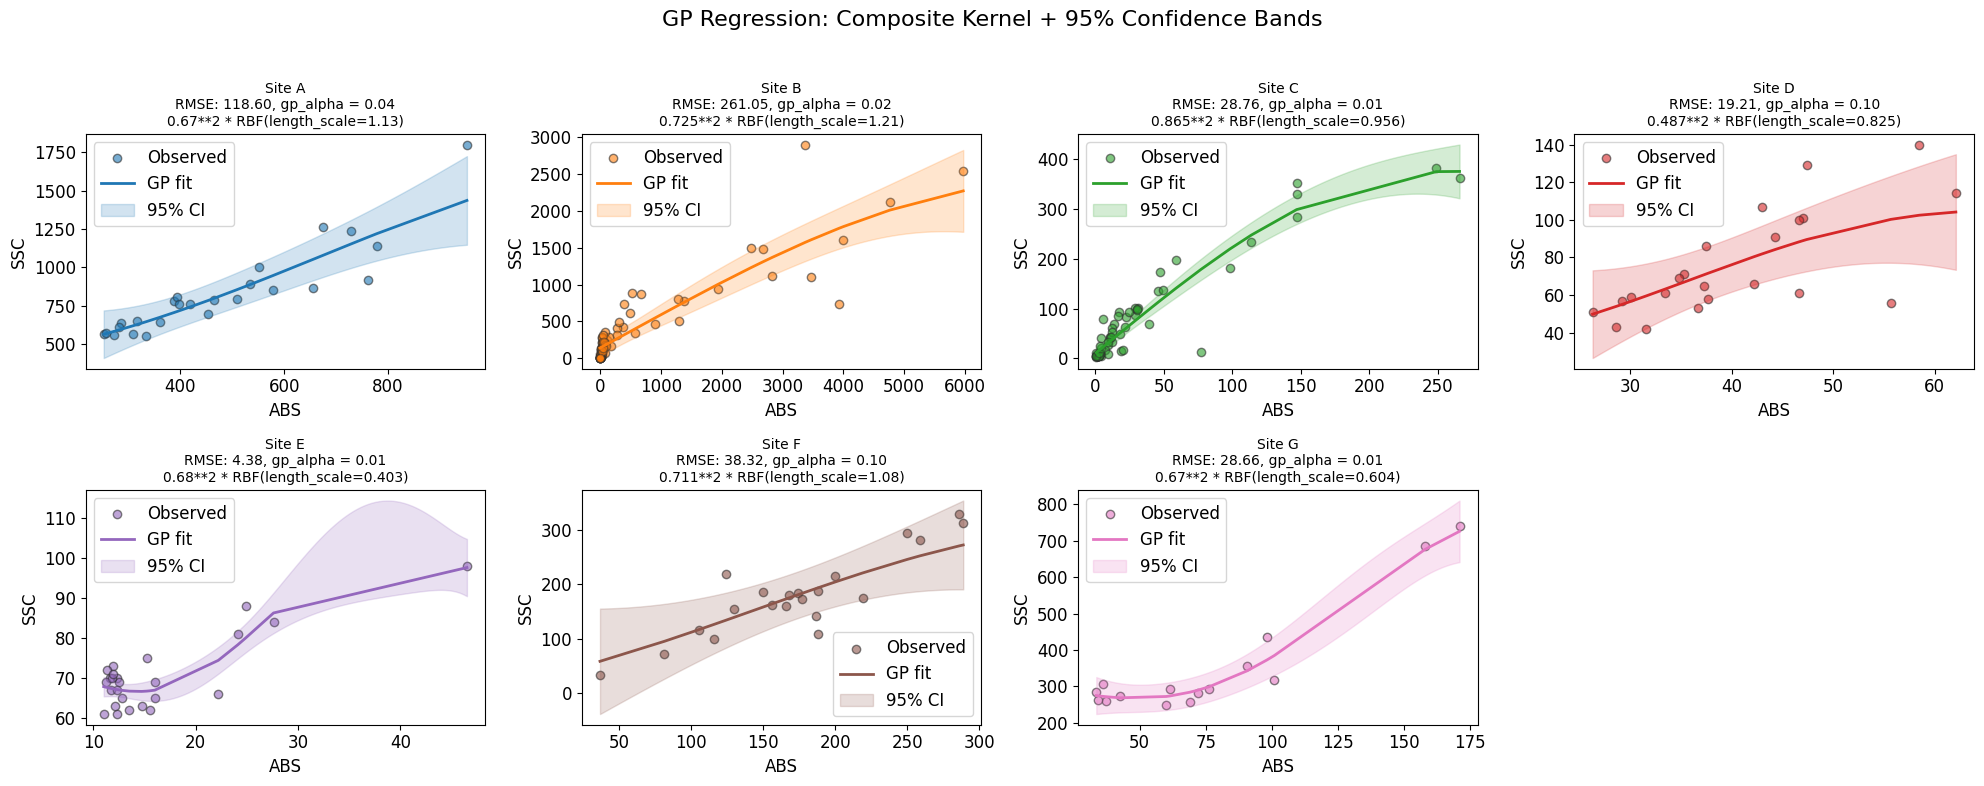

In [5]:
# === Plotting ===
site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5* n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]
    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    gp_alpha = model['scores']['alpha']
    print(f'Site {site_id} model hyperparams: {model["hyperparams"]}')

    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]

    color = f"C{i % 10}"
    marker = 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    ax.fill_between(SAC_pred_all,
                    SSC_pred_all - 1.96 * std_all,
                    SSC_pred_all + 1.96 * std_all,
                    color=color, alpha=0.2, label='95% CI')

    try:
        kernel_str = str(model['model'].kernel_)
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha:.2f}\n{kernel_str}",
        fontsize=10
    )
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Hide unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.suptitle('GP Regression: Composite Kernel + 95% Confidence Bands', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [12]:
def const_rbf_kernel(x, y, length_scale, const):
    rbf = math.exp(- math.dist([x],[y]) / (2*length_scale**2) )
    return const * rbf

def cov_to_cor(cov):
    d = np.sqrt(np.diag(cov))
    return cov / np.outer(d, d)

correlation_matrices = {}
n_range = [20, 25, 50, 100]

for id in alpha_site_id:
    correlation_matrices[id] = {}
    mod = model_dictionary[id]
    x = np.array(mod['x'])
    y = np.array(mod['y'])
    pred_x = mod['p_pred'][0]
    pred_y = mod['p_pred'][1]

    # Hyperparameters 
    hp = mod['hyperparams']
    print(hp)
    const = hp.get('k1__constant_value', None)
    l = hp.get('k2__length_scale', None)


    if l is None or const is None:
        raise ValueError(f"Missing hyperparameter in site {id}")


    # Sort input data
    ord = np.argsort(x)
    x_sort = x[ord]
    y_sort = y[ord]

    # Raw range
    x_min = np.min(x_sort)
    x_max = np.max(x_sort)

    x_sort_scaled = (x_sort - x_min) / (x_max - x_min)

    # --- Fixed range, variable number of prediction points ---
    correlation_matrices[id]['n'] = {}
    for n in n_range:
        # since models trained scaled to 0 to 1, use same range
        nx_trend_scaled = np.linspace(0, 1, n)
        kern = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                kern[i, j] = const_rbf_kernel(nx_trend_scaled[i], nx_trend_scaled[j], l, const)
        cor_mat = cov_to_cor(kern)

        correlation_matrices[id]['n'][n] = {
            'hyperparams': {
                'length_scale': l,
                'constant_value': const,
            },
            'cor_matrix': cor_mat,
            'range': nx_trend_scaled * (x_max - x_min) + x_min,  # Rescale to original range
            'range_scaled': nx_trend_scaled,
        }

    # --- Across sites: use each model's kernel on this site's inputs ---
    correlation_matrices[id]['num_samp'] = {}
    for model_id in alpha_site_id:
        # get model hyperparemeter to use at site id
        # Hyperparameters (decoded with exp)
        hp_mod = model_dictionary[model_id]['hyperparams']
        const_mod = hp_mod.get('k1__constant_value', None)
        l_mod = hp_mod.get('k2__length_scale', None)
        samp_n = len(x_sort_scaled)

        kern = np.zeros((samp_n, samp_n))
        # use scaled x_sort for consistency with model training
        for i in range(samp_n):
            for j in range(samp_n):
                kern[i, j] = const_rbf_kernel(x_sort_scaled[i], x_sort_scaled[j], l_mod, const_mod)
        cor_mat = cov_to_cor(kern)
        print(l_mod, const_mod, id, site_id, model_id, samp_n, x_sort_scaled[0], x_sort_scaled[-1])

        correlation_matrices[id]['num_samp'][model_id] = {
            'hyperparams': {
                'length_scale': l_mod,
                'constant_value': const_mod,
            },
            'cor_matrix': cor_mat,
            'range': x_sort,
            'range_scaled': x_sort_scaled,
            'n': samp_n,
        }
        print(correlation_matrices[id]['num_samp'][model_id]['cor_matrix'].shape, id, model_id)


{'k1__constant_value': 0.4487178911185129, 'k2__length_scale': 1.1277990936160096}
1.1277990936160096 0.4487178911185129 A G A 25 0.0 1.0
(25, 25) A A
1.2092976970817648 0.5254686987695594 A G B 25 0.0 1.0
(25, 25) A B
0.9563757805306794 0.7474163057572575 A G C 25 0.0 1.0
(25, 25) A C
0.8251007330335435 0.23729863806364207 A G D 25 0.0 1.0
(25, 25) A D
0.40284013577200506 0.46189225057770683 A G E 25 0.0 1.0
(25, 25) A E
1.0822987991198956 0.5049068296746096 A G F 25 0.0 1.0
(25, 25) A F
0.6041473781708283 0.4485602461285016 A G G 25 0.0 1.0
(25, 25) A G
{'k1__constant_value': 0.5254686987695594, 'k2__length_scale': 1.2092976970817648}
1.1277990936160096 0.4487178911185129 B G A 68 0.0 1.0
(68, 68) B A
1.2092976970817648 0.5254686987695594 B G B 68 0.0 1.0
(68, 68) B B
0.9563757805306794 0.7474163057572575 B G C 68 0.0 1.0
(68, 68) B C
0.8251007330335435 0.23729863806364207 B G D 68 0.0 1.0
(68, 68) B D
0.40284013577200506 0.46189225057770683 B G E 68 0.0 1.0
(68, 68) B E
1.0822987991

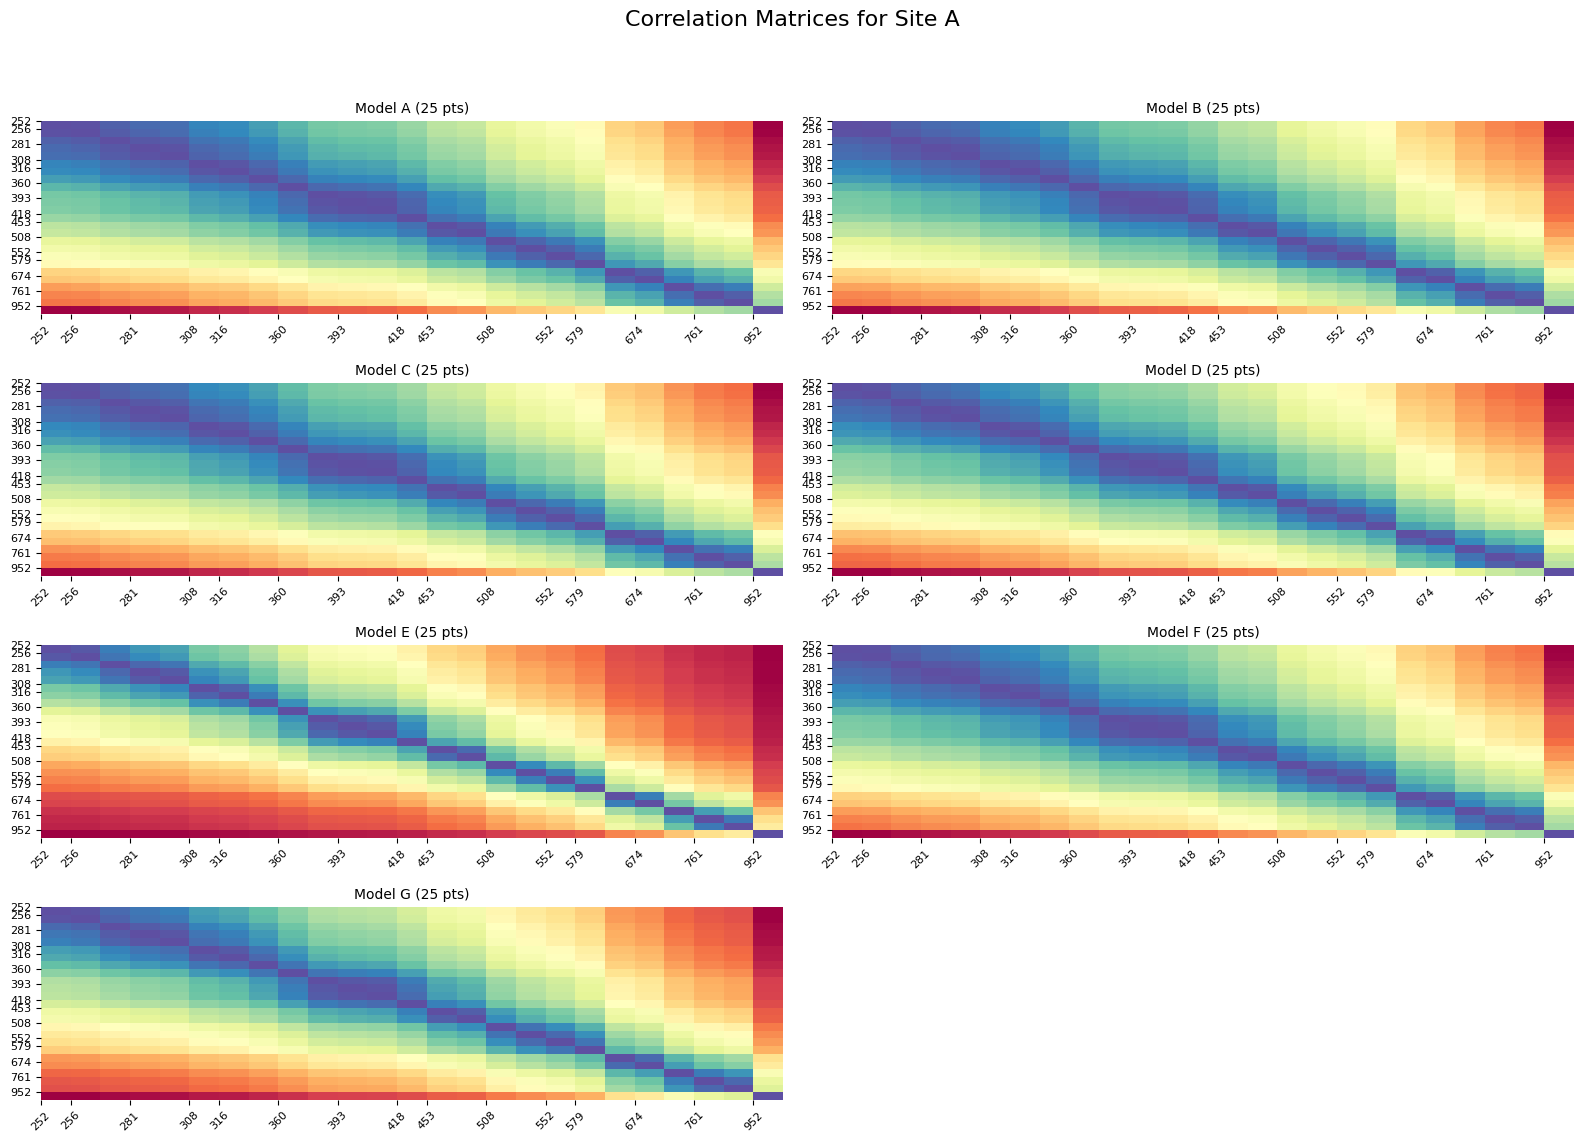

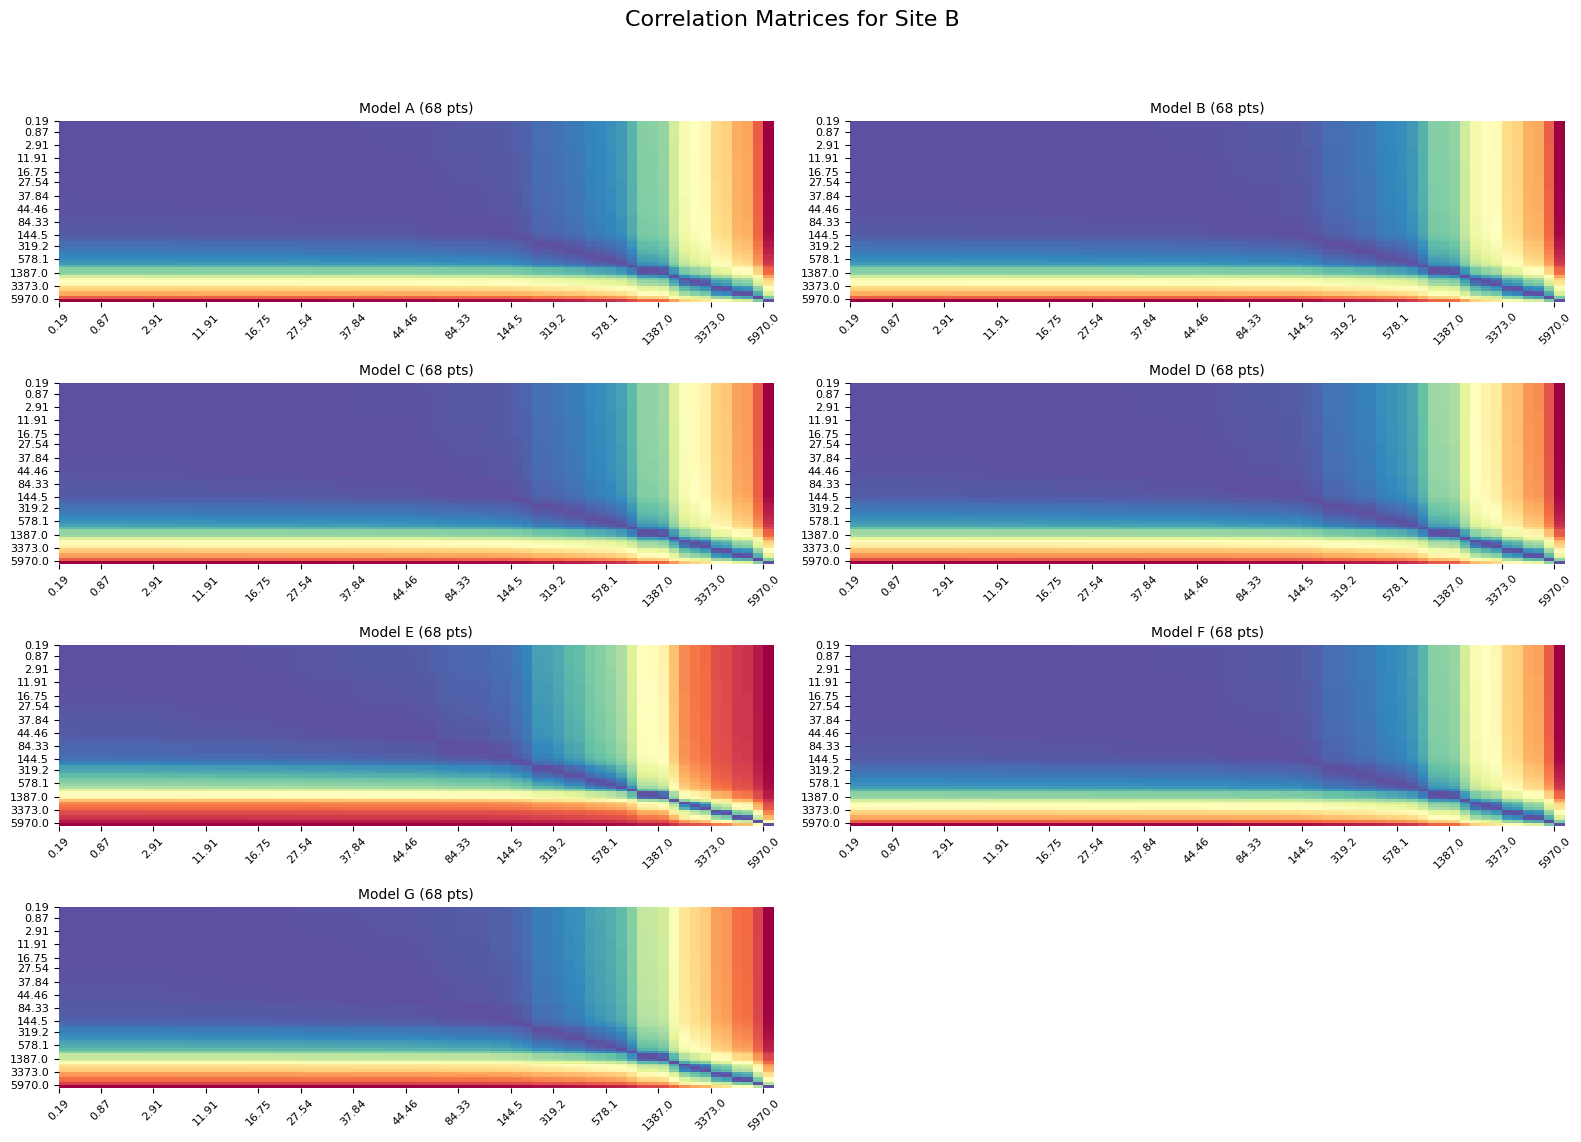

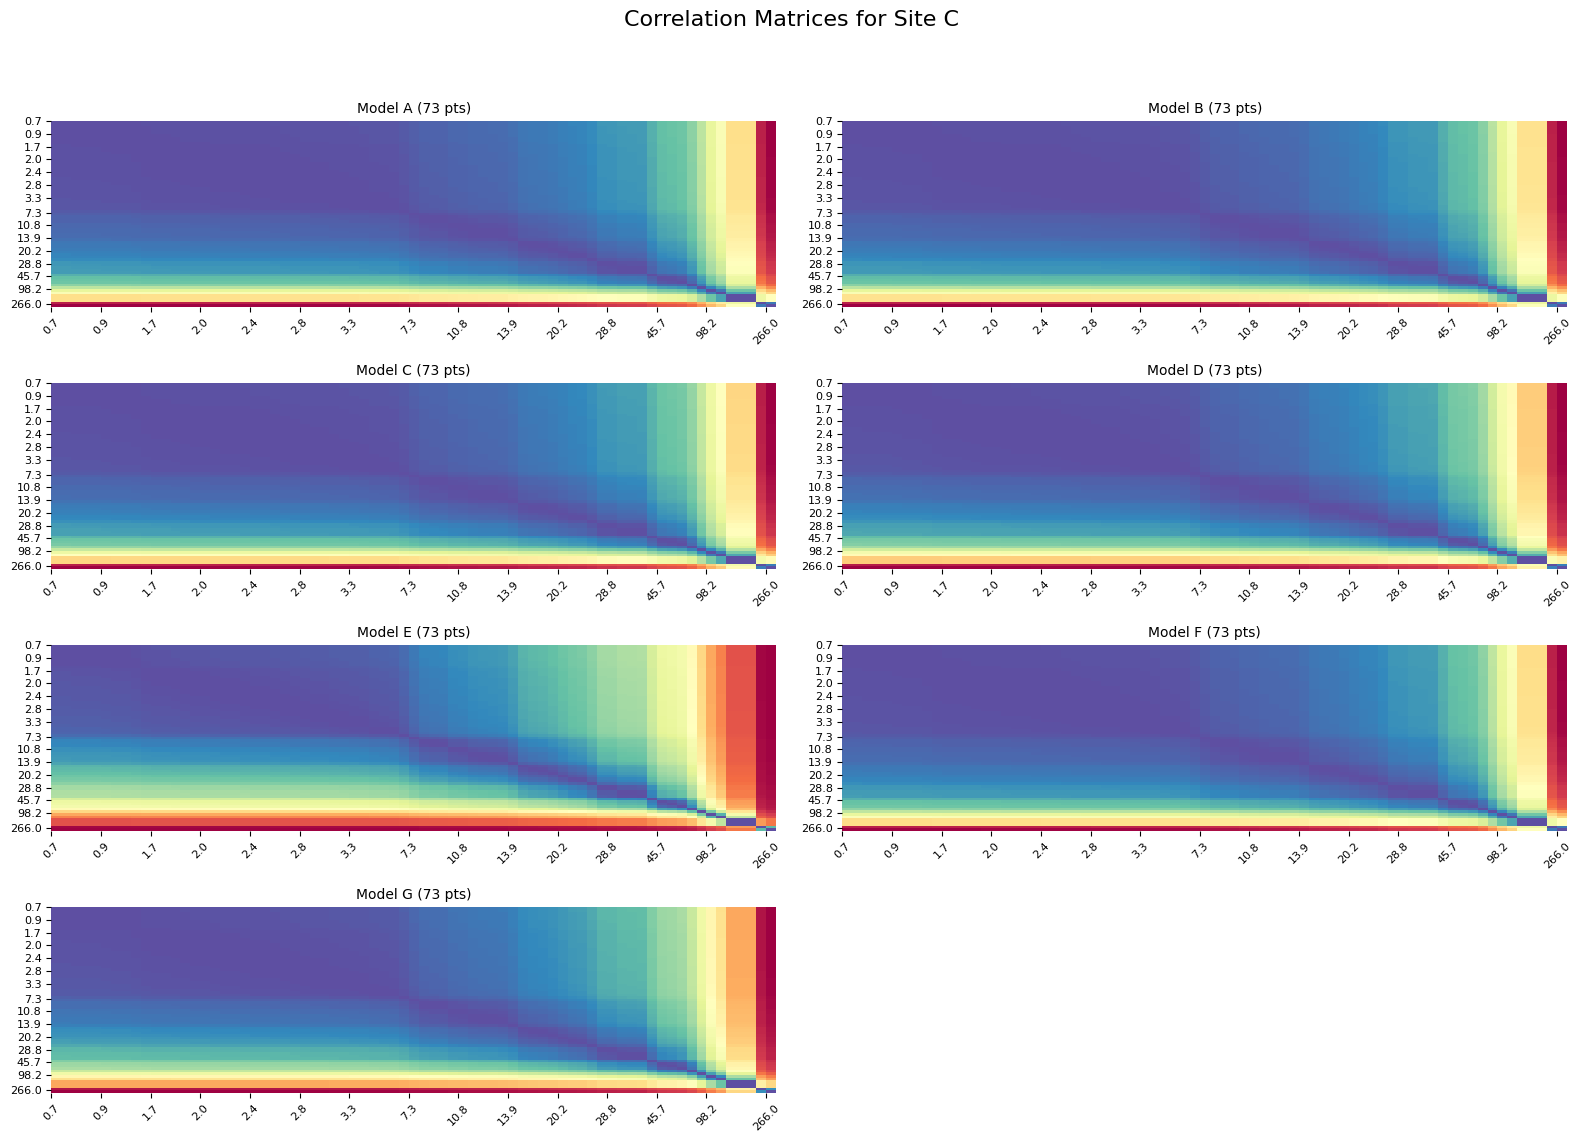

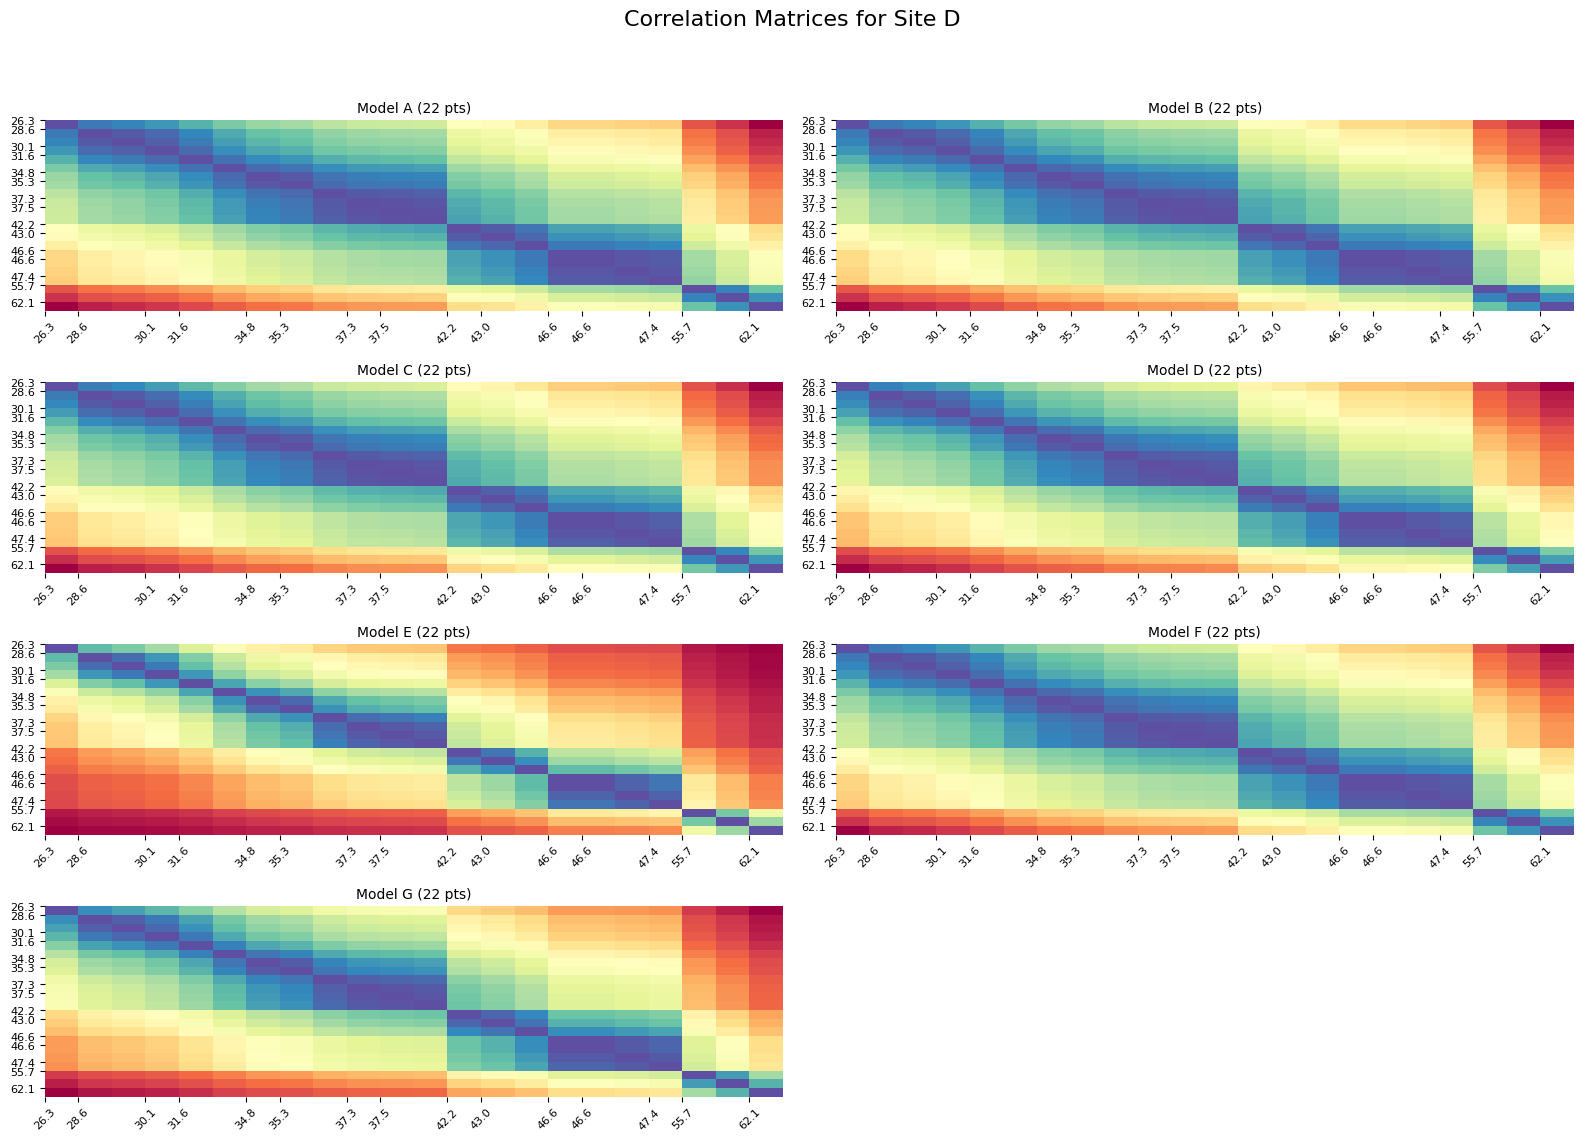

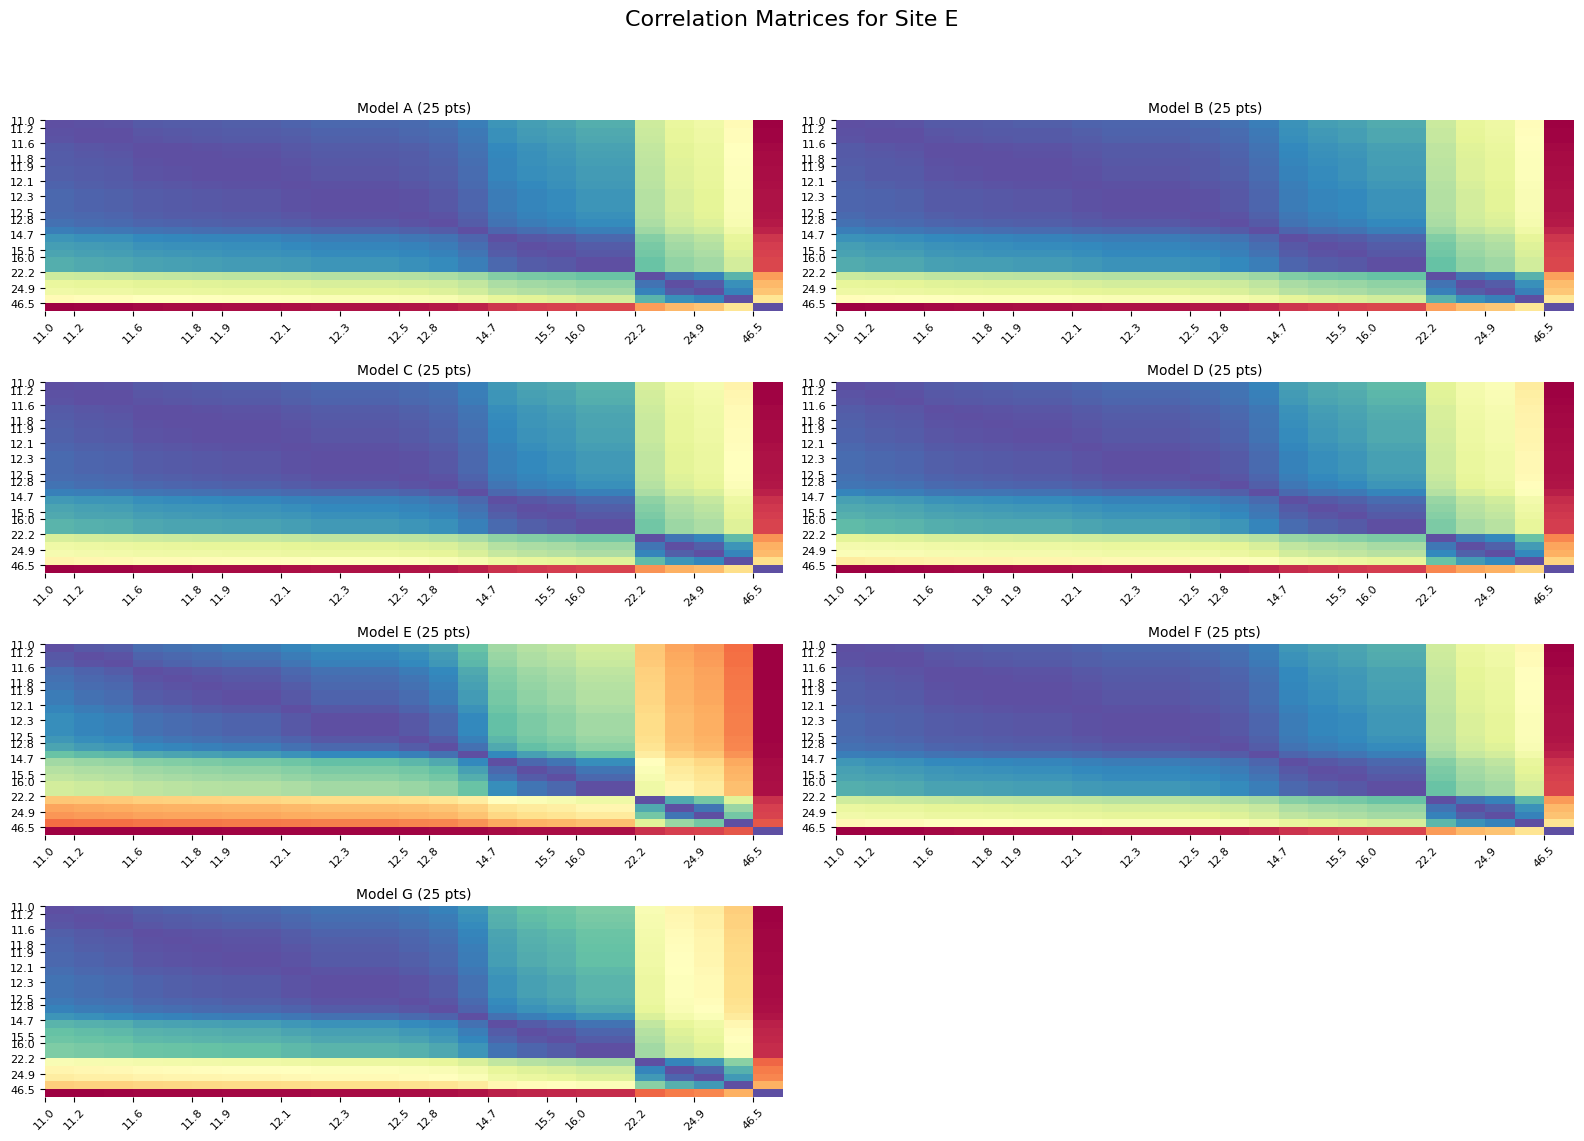

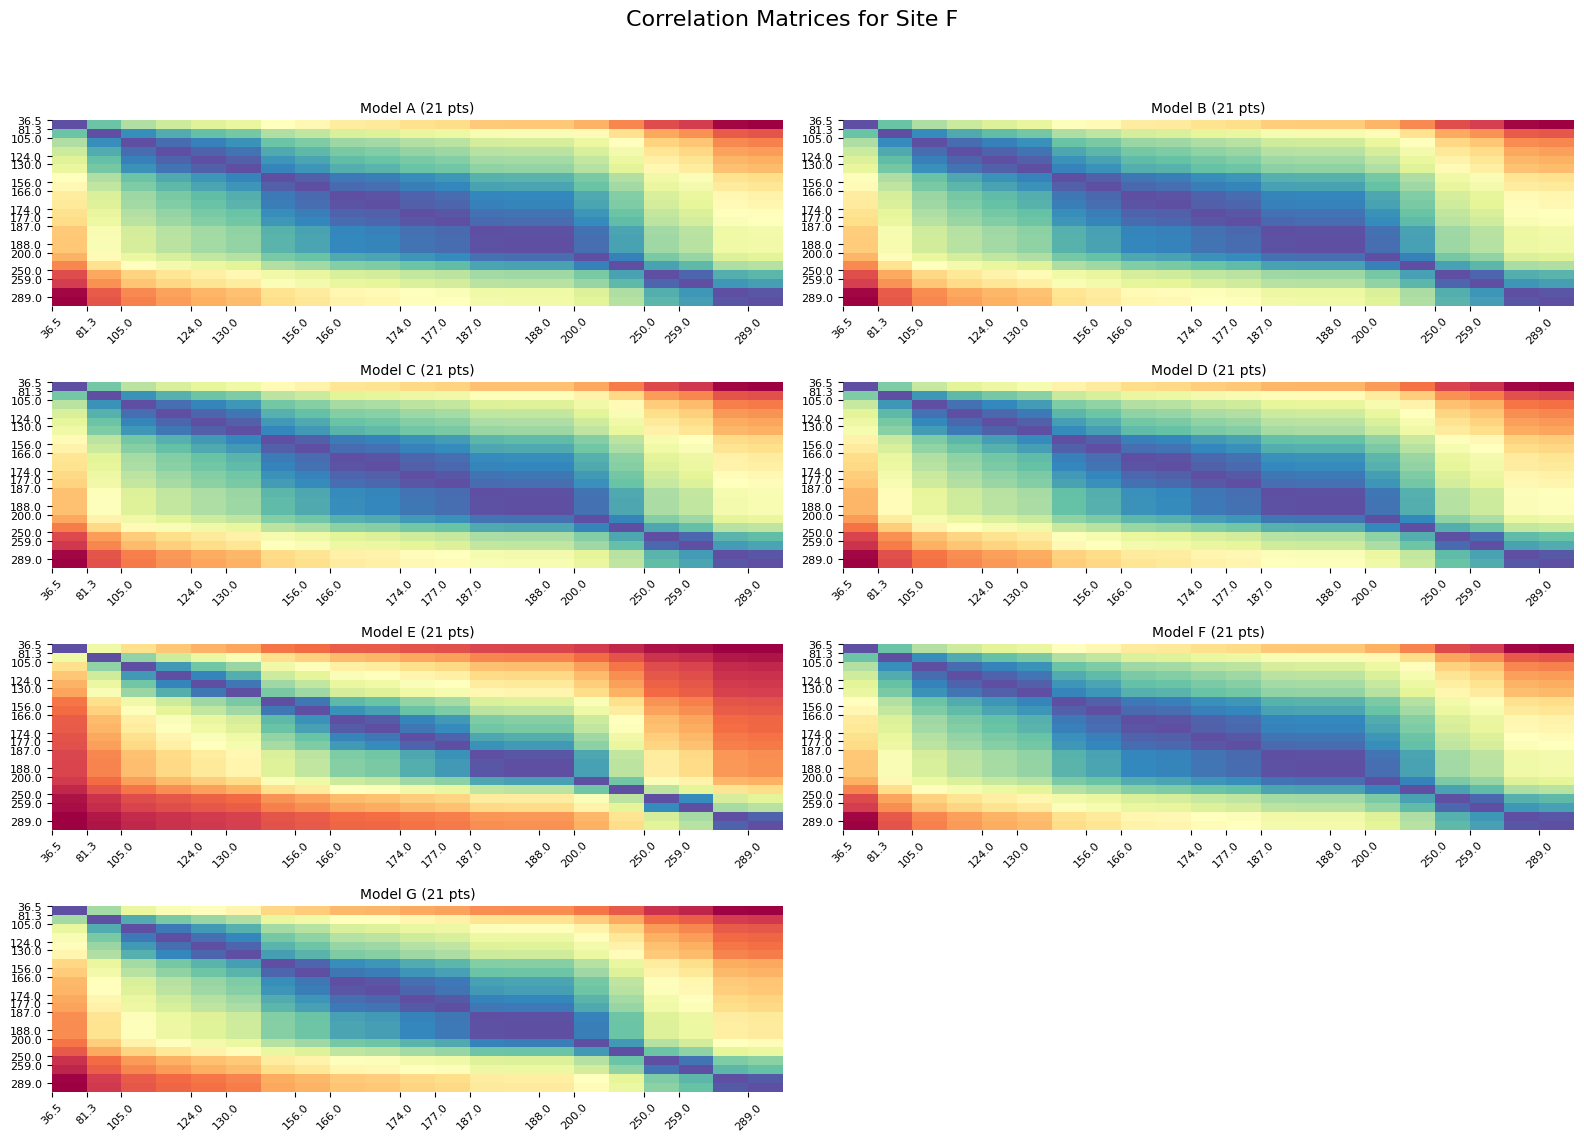

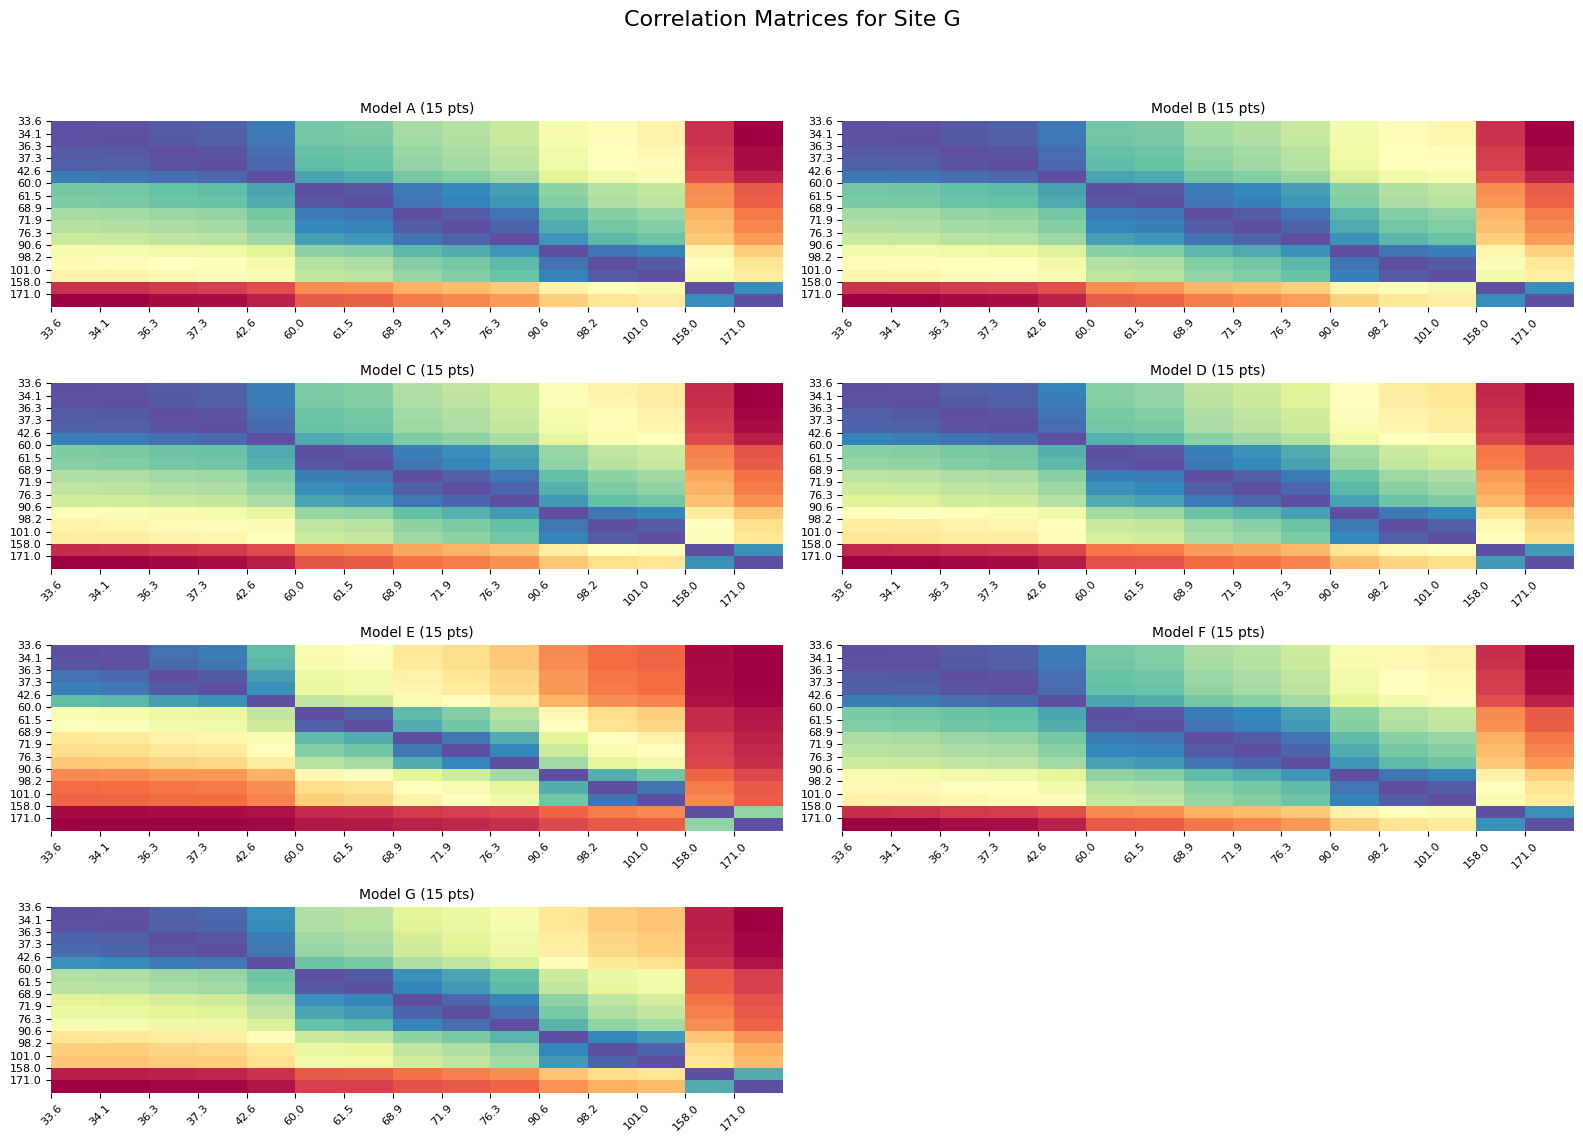

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for id, models in correlation_matrices.items():
    num_models = len(models['num_samp'])
    num_plots = min(num_models, 7)  # max 7 subplots per figure
    nrows, ncols = 4, 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(4* n_cols, 6* n_rows))
    axes = axes.flatten()

    for index, (model_id, data) in enumerate(models['num_samp'].items()):
        if index >= len(axes):
            break

        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        n_points = len(nx_trend)

        # Decide whether to annotate or use tick labels based on matrix size
        show_ticks = n_points <= 20
        xticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        yticks = np.round(np.sort(nx_trend), 2) if show_ticks else False
        nx_trend_sorted = np.sort(nx_trend)  # make sure x is sorted

        # Decide how many ticks to show (15 or fewer)
        n_total = len(nx_trend_sorted)
        n_ticks = min(15, n_total)

        # Get tick indices evenly spaced by index
        tick_indices = np.linspace(0, n_total - 1, n_ticks, dtype=int)
        tick_labels = np.round(nx_trend_sorted[tick_indices], 2)

        sns.heatmap(
            cor_mat,
            cbar=False,
            annot=False,  # turn on if n_points is small and needed
            cmap="Spectral",
            fmt='.2f',
            ax=axes[index],
            xticklabels=False,
            yticklabels=False
        )
        axes[index].set_title(f'Model {model_id} ({n_points} pts)', fontsize=10)
        # Set manual ticks and labels
        axes[index].set_xticks(tick_indices)
        axes[index].set_xticklabels(tick_labels, rotation=45, fontsize=8) 


        axes[index].set_yticks(tick_indices)
        axes[index].set_yticklabels(tick_labels, fontsize=8)

    # Hide any unused axes
    for j in range(index + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Correlation Matrices for Site {id}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # Optional: save to file
    # plt.savefig(f'correlation_matrices_site_{id}.png', dpi=150)
    plt.close()


In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

site_ids = list(correlation_matrices.keys())
n_sites = len(site_ids)

# Frobenius distance matrix (models vs sites)
fro_rel_matrix = np.zeros((n_sites, n_sites))

for i, model_site in enumerate(site_ids):
    for j, target_site in enumerate(site_ids):
        try:
            # Model from model_site, applied to target_site
            A = correlation_matrices[target_site]['num_samp'][model_site]['cor_matrix']

            # Reference matrix: model trained & applied on target_site itself
            B = correlation_matrices[target_site]['num_samp'][target_site]['cor_matrix']
            n = B.shape[0]

            # Option 1: normalized by sqrt(n)
            norm_diff = np.linalg.norm(A - B, 'fro') / np.sqrt(n)

            # Option 2: relative to reference matrix norm
            ref_norm = np.linalg.norm(B, 'fro')
            rel_diff = np.linalg.norm(A - B, 'fro') / ref_norm if ref_norm != 0 else np.nan

            fro_rel_matrix[i, j] = rel_diff  # use rel_diff or norm_diff

        except KeyError:
            continue  # Leave as NaN if matrix doesn't exist


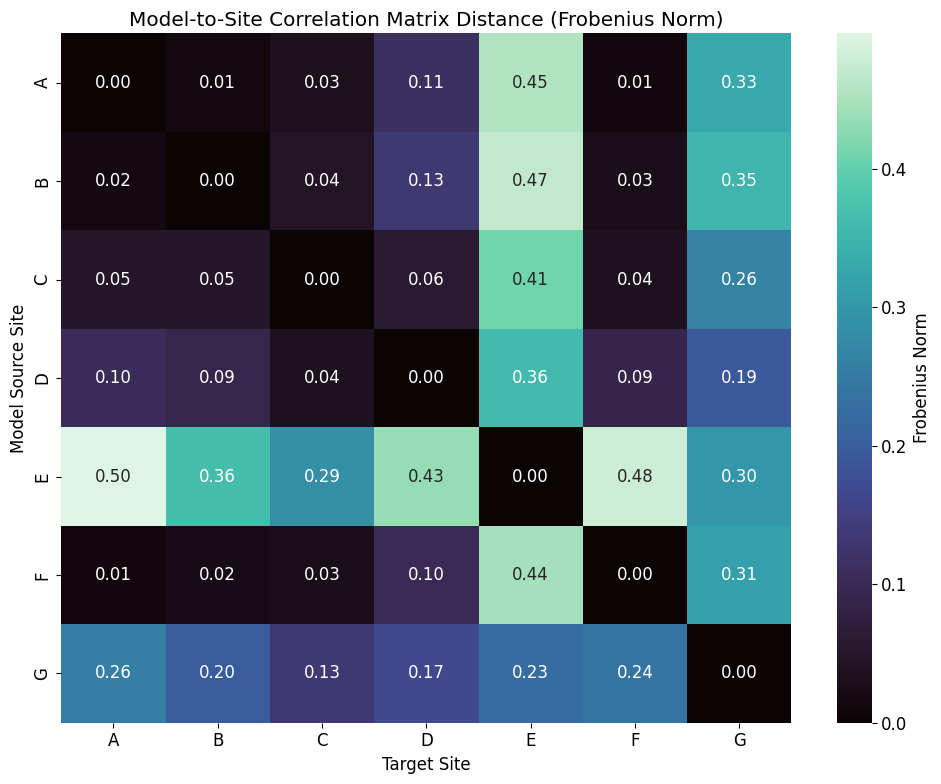

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(fro_rel_matrix, annot=True, fmt=".2f", cmap="mako", 
            xticklabels=site_ids, yticklabels=site_ids, cbar_kws={'label': 'Frobenius Norm'})

plt.xlabel("Target Site")
plt.ylabel("Model Source Site")
plt.title("Model-to-Site Correlation Matrix Distance (Frobenius Norm)")
plt.tight_layout()
plt.show()


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(<Figure size 700x500 with 1 Axes>, <Figure size 700x500 with 1 Axes>)

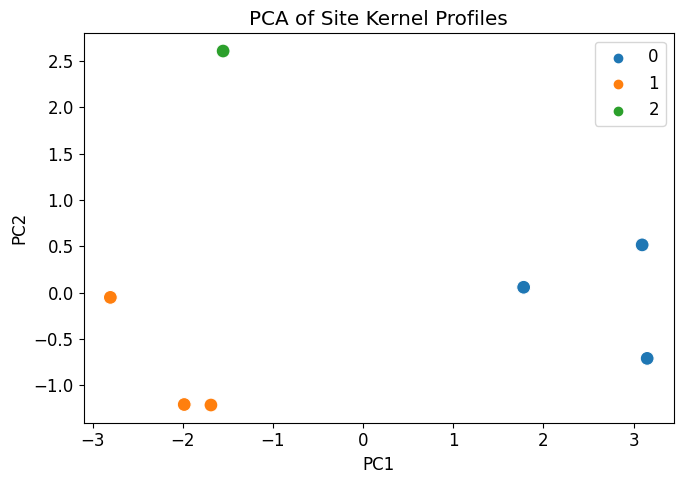

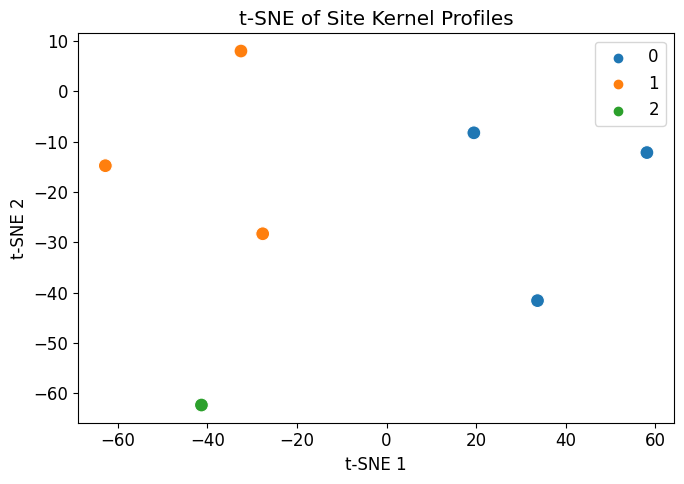

In [314]:
# Re-import necessary libraries after code execution environment reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Simulated kernel profile table (replace with actual values later)
# Columns: alpha, const, l, l/const, l/const^2, l*const, const*l^2, const^2/l
site_names = ['b', 'c', 'f','a', 'e', 'd', 'g']
data = np.array([
    [0.02, 0.725, 1.21, 1.6689, 2.3020, 0.877, 0.636, 1.061],
    [0.01, 0.865, 0.956, 1.1052, 1.2776, 0.827, 0.715, 0.790],
    [0.1, 0.711, 1.08, 1.5190, 2.1364, 0.768, 0.546, 0.829],
    [0.04, 0.670, 1.13, 1.6866, 2.5172, 0.757, 0.507, 0.855],
    [0.01, 0.680, 0.403, 0.5926, 0.8715, 0.274, 0.186, 0.110],
    [0.1, 0.680, 0.405, 0.5956, 0.8758, 0.275, 0.187, 0.111],
    [0.01, 0.670, 0.604, 0.9015, 1.3455, 0.405, 0.271, 0.244]
])

labels = ['alpha', 'const', 'l', 'l/const', 'l/const^2', 'l*const', 'const*l^2', 'const^2/l']

# Scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
# data_scaled = data

# PCA for 2D projection
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# t-SNE for nonlinear structure
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(data_scaled)

# KMeans clustering (you can adjust n_clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Plot PCA
fig_pca, ax_pca = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_pca)
ax_pca.set_title("PCA of Site Kernel Profiles")
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")

# Plot t-SNE
fig_tsne, ax_tsne = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_tsne)
ax_tsne.set_title("t-SNE of Site Kernel Profiles")
ax_tsne.set_xlabel("t-SNE 1")
ax_tsne.set_ylabel("t-SNE 2")

fig_pca.tight_layout()
fig_tsne.tight_layout()
fig_pca, fig_tsne


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


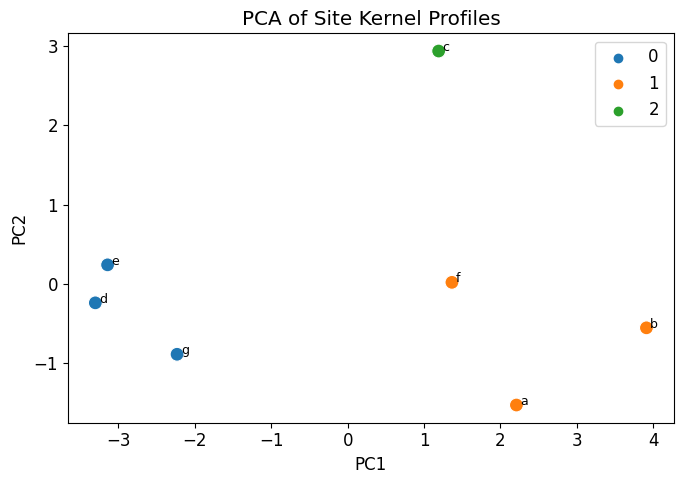

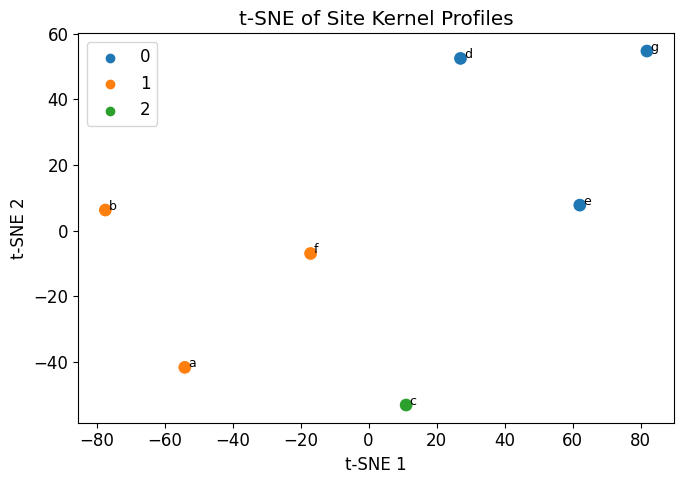

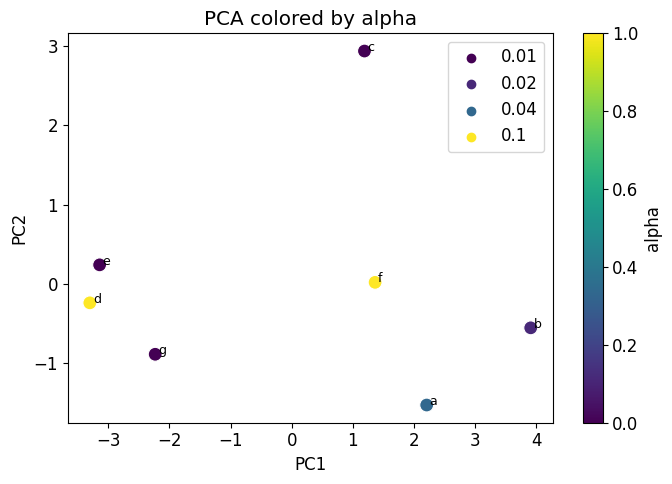

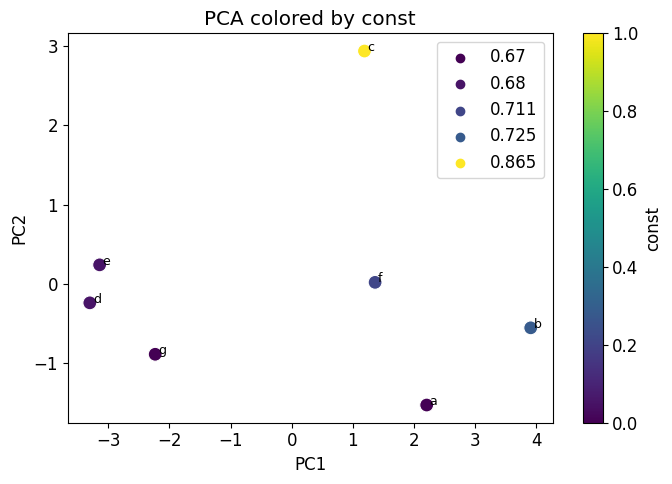

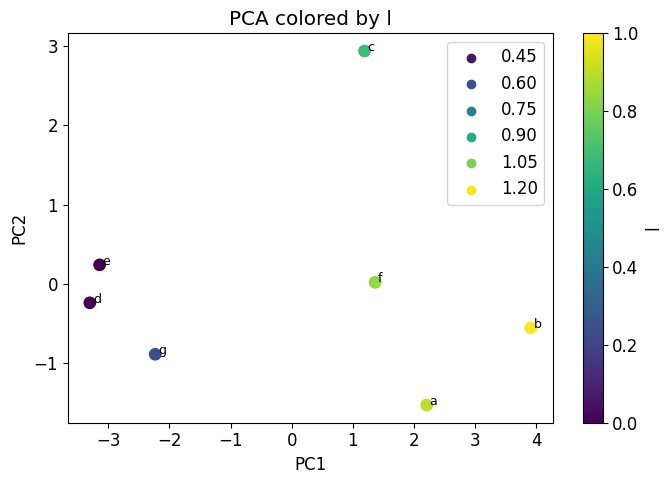

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Simulated kernel profile table (replace with actual values later)
site_names = ['b', 'c', 'f','a', 'e', 'd', 'g']
data = np.array([
    [0.02, 0.725, 1.21, 1.6689, 2.3020, 0.877, 0.636, 1.061, 0.33,	6000,	2000],
    [0.01, 0.865, 0.956, 1.1052, 1.2776, 0.827, 0.715, 0.790, 1.33,	300,	400],
    [0.1, 0.711, 1.08, 1.5190, 2.1364, 0.768, 0.546, 0.829, 1.33,	300,	400],
    [0.04, 0.670, 1.13, 1.6866, 2.5172, 0.757, 0.507, 0.855, 2, 1000, 2000],
    [0.01, 0.680, 0.403, 0.5926, 0.8715, 0.274, 0.186, 0.110, 2, 50, 100],
    [0.1, 0.680, 0.405, 0.5956, 0.8758, 0.275, 0.187, 0.111, 2.5, 60, 150],
    [0.01, 0.670, 0.604, 0.9015, 1.3455, 0.405, 0.271, 0.244, 4.57, 175, 800]
])
labels = ['alpha', 'const', 'l', 'l/const', 'l/const^2', 'l*const', 'const*l^2', 'const^2/l', 'X/Y', 'maxX','maxY]']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(data_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# --- PCA plot with labels ---
fig_pca, ax_pca = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_pca)
for i, txt in enumerate(site_names):
    ax_pca.text(pca_result[i, 0]+0.05, pca_result[i, 1], txt, fontsize=9)
ax_pca.set_title("PCA of Site Kernel Profiles")
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")

# --- t-SNE plot with labels ---
fig_tsne, ax_tsne = plt.subplots(figsize=(7, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=clusters, palette="tab10", s=100, ax=ax_tsne)
for i, txt in enumerate(site_names):
    ax_tsne.text(tsne_result[i, 0]+1.0, tsne_result[i, 1], txt, fontsize=9)
ax_tsne.set_title("t-SNE of Site Kernel Profiles")
ax_tsne.set_xlabel("t-SNE 1")
ax_tsne.set_ylabel("t-SNE 2")

fig_pca.tight_layout()
fig_tsne.tight_layout()

# --- Optional: PCA plots colored by feature (e.g., alpha, const, l) ---
features_to_color = ['alpha', 'const', 'l']
for idx, feature in enumerate(features_to_color):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                    hue=data[:, idx], palette="viridis", s=100, ax=ax)
    for i, txt in enumerate(site_names):
        ax.text(pca_result[i, 0]+0.05, pca_result[i, 1], site_names[i], fontsize=9)
    ax.set_title(f"PCA colored by {feature}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    plt.colorbar(ax.collections[0], label=feature)
    plt.tight_layout()

plt.show()
